# Acoustic wavefield separation - Volve data

**Author: M.Ravasi**

This notebook applies multi-component wavefield separation to the Volve data

In [58]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import segyio
import pylops
import torch
import torchvision
import torch.nn as nn
import pylops_gpu


from scipy.signal import butter, lfilter, freqz, medfilt, fftconvolve
from scipy.sparse import csr_matrix, vstack
from scipy.signal import filtfilt
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing import *
from pylops.waveeqprocessing.wavedecomposition import *
from pylops.waveeqprocessing.mdd import MDC, MDD
from pylops.optimization.leastsquares  import *

from segyshot import SegyShot
from wavsep_utils import *
from stochmdd import MDDminibatch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Parameters

In [59]:
# Geometry
ishotin, ishotend, ishotc = 5370, 5670, 5520
irecin, irecend = 30, 210

# Corrupted traces
clip = 1e5
izmin = 200
nmed = 7
threshmax = 1.4
threshmin = 0.4

# Filtering
fmax = 35.
nlpf = 5

# Calibration
nfilt = 11
twin = [0.03, 0.08]

    
# fk filter
critical = 0.95
ntapermask = 5

# Separation
vel_dir = 1500.

# water
vel_sep=1500 # velocity at separation level
rho_sep=1000 # density at separation level

# seabed
#vel_sep = 1800.0 # velocity at separation level
#rho_sep = 1200.0 # density at separation level

# Data loading

In [60]:
velfilepath = '/home/ravasim/Documents/Data/Volve/ST10010ZC11-MIG-VEL.MIG_VEL.VELOCITY.3D.JS-017527.segy'
filepath = '/home/ravasim/Documents/Data/Volve/'

[1480.     1480.     1480.     1498.4617 1559.6826 1662.0117 1762.7058
 1817.606  1831.2026 1833.5603 1832.5757 1829.2246 1825.5374 1823.6853
 1826.4695 1835.04   1849.1775 1867.0715 1886.7537 1906.2708 1924.065
 1939.2146 1951.396  1960.5903 1966.9758 1970.8765 1973.1445 1978.2119
 1989.8799 2008.2261 2025.2942 2037.5015 2046.0139 2056.2952 2069.311
 2084.303  2100.2769 2116.0557 2130.3857 2141.4556 2143.078  2129.9814
 2103.1807 2076.4336 2057.3762 2047.6221 2041.6343 2038.7385 2039.3962
 2043.4246 2049.353  2056.1418 2063.646  2072.956  2083.588  2094.2021
 2102.9182 2109.2253 2113.0718 2114.9934 2115.865  2116.3933 2117.6094
 2119.791  2120.7156 2119.1582 2116.7805 2118.752  2126.0276 2136.2021
 2145.7437 2153.8425 2160.338  2165.2056 2168.5742 2170.9358 2172.777
 2174.57   2176.6038 2178.9824 2181.9487 2185.6003 2189.9355 2194.7292
 2199.6316 2204.5115 2209.208  2213.6094 2217.077  2215.5183 2205.4797
 2187.967  2172.6511 2163.759  2160.8247 2158.7312 2156.7134 2155.2827
 2154.242

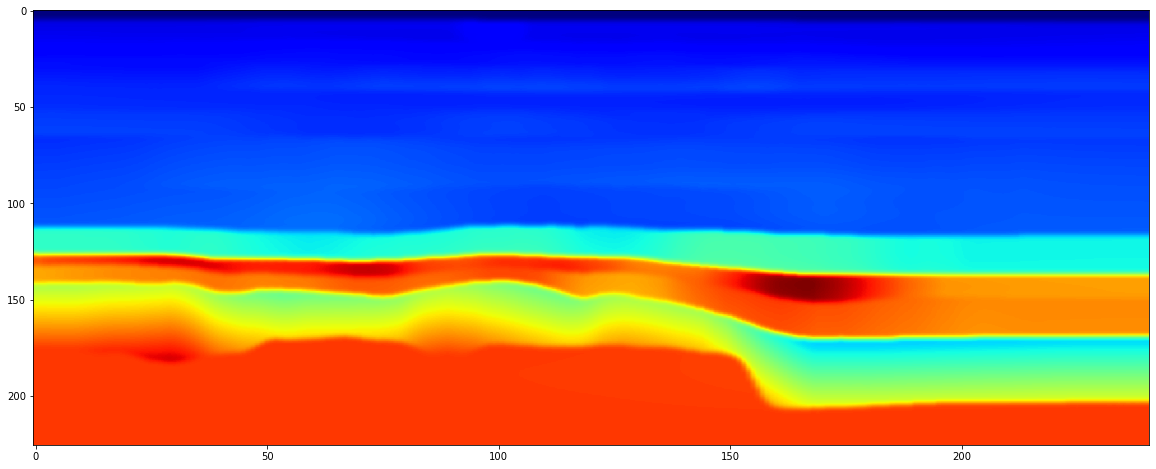

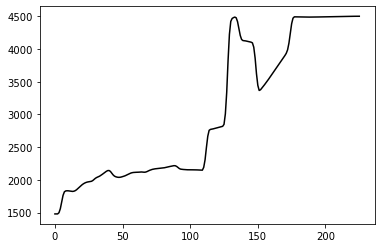

In [61]:
vmod = segyio.cube(velfilepath)

plt.figure(figsize=(20, 8))
plt.imshow(vmod[50].T, cmap='jet')
plt.axis('tight');

plt.figure()
plt.plot(vmod[50, 120], 'k')

print(vmod[50, 120])

In [62]:
inputfile = os.path.join(filepath, 'ST10010_1150780_40203.sgy')
f = segyio.open(inputfile, ignore_geometry=True)

In [63]:
print(segyio.tools.wrap(f.text[0]))    

C 1 CLIENT: STATOIL           COMPANY: RESERVOIR EXPLORATION TECHNOLOGY
C 2 AREA: VOLVE NORWAY BLOCK 15/9                SURVEY: ST10010
C 3 SWATH:  11                             VESSELS:M/V VIKLAND, M/V SANCO
SPIRITC 4 RCV LINE: 1150780    RCVR RANGE: 1239-1717
C 5 DATA-SET: NAV MERGE   TRACES PER RECORD: 240 X 4   SEQ: 094-133
C 6 RECORDING FORMAT: IEEE SEG-Y           FORMAT THIS REEL: SEG-Y 3592
C 7 SAMPLE CODE: FLOATING PT               PROCESSED: 03/11/2010
C 8 ACQ. GEOM: 8 ROLL 8  INLINE SWATH      LINE PREFIX: ST10010
C 9 INSTRUMENT: VECTORSEIS OCEAN BOTTOM    RECORDING SYSTEM DELAY: 0 MS
C10 RECORDING FILTER: 1.5/6-187/260MIN PHS DESCRIPTION: HZ/DB PER OCTAVE
C11 NO OF RECEIVER LINES/SWATH: 8          RECEIVER LINE SEPARATION: 400/200M
C12 ACTIVE CABLE LENGTH: 5975M             RCVRS / RCV LINE 240 X 4
C13 NO OF SOURCES:  2                      SOURCE SEPARATION: 50M
C14 RECEIVER INTERVAL: 25M                 SHOT INTERVAL: 25M, FLIP/FLOP
C15 DATUM: ED50, 31N  SPHEROID: INT. 

## Data inspection

Local regular axis:
 ox=0.000000, dx=49.793406 nx=241
 oy=-0.000000, dy=49.540976 ny=109


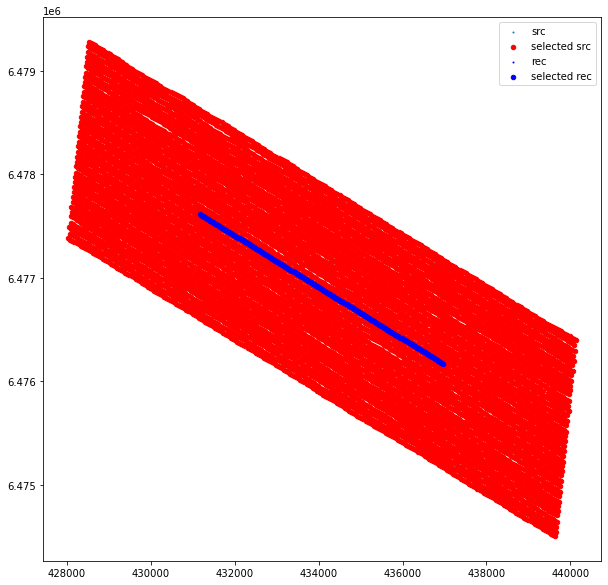

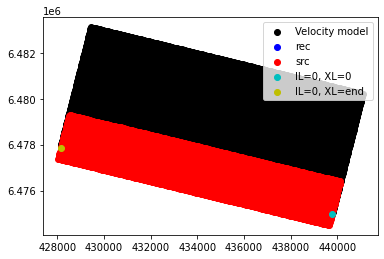

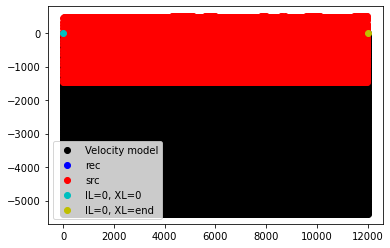

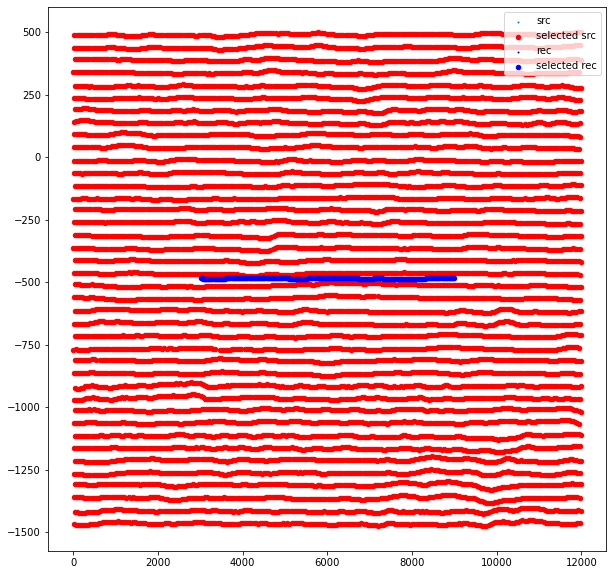

In [64]:
sg = SegyShot(inputfile, components=['P', 'VZ', 'VX', 'VY'])
sg.interpret()
sg.showgeometry()

sg.rotategeometry(velfile=velfilepath, plotflag=1)
sg.showgeometry(local=True)

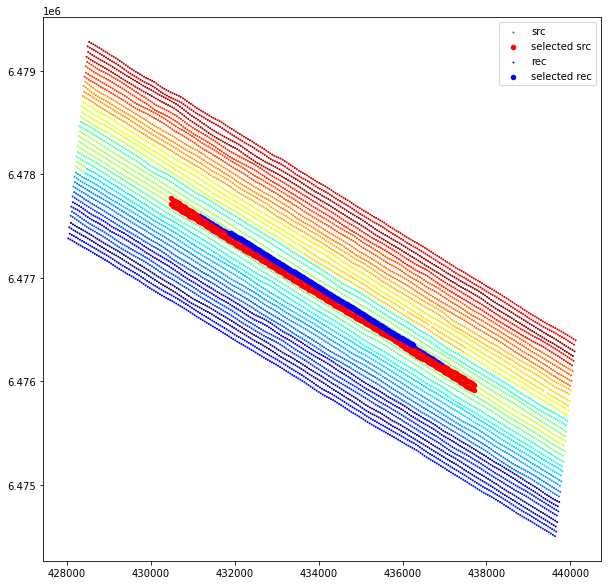

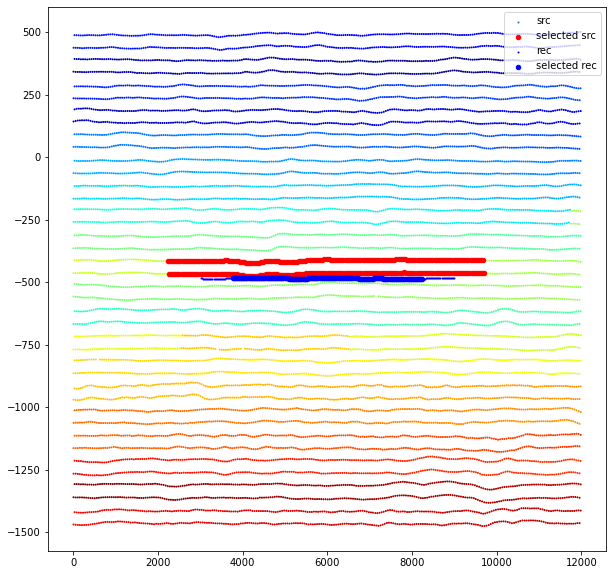

In [65]:
sg.selectrecs(irecin, irecend, plotflag=False)
sg.selectsrcs(ishotin, ishotend, plotflag=False)
sg.showgeometry()
sg.showgeometry(local=True)

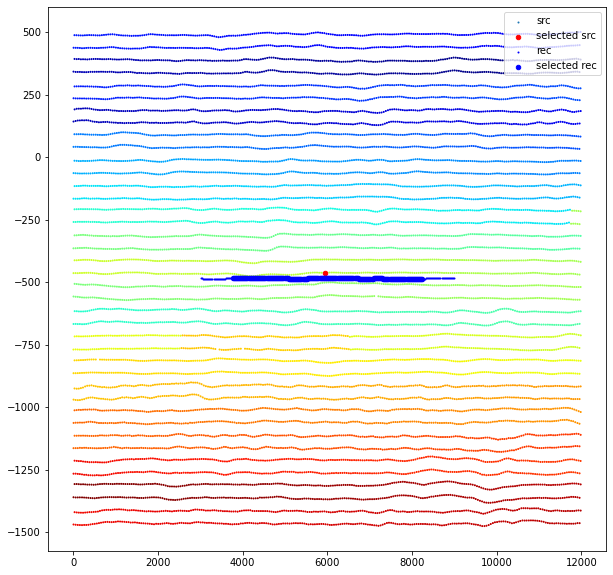

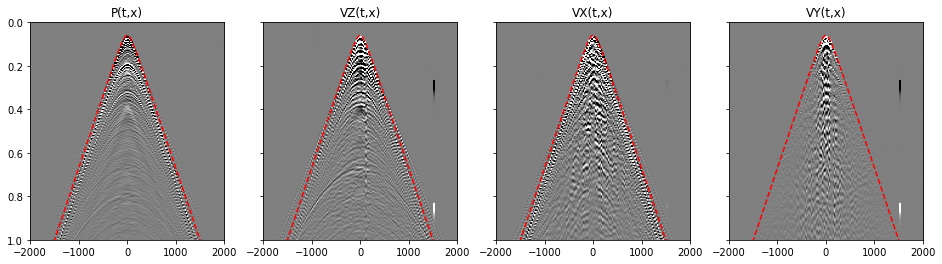

In [66]:
sg.selectsrcs(ishotc, ishotc+1, plotflag=False)
sg.showgeometry(local=True)

drec = np.mean(np.abs(np.diff(sg.recx_local)))
offset = np.sqrt((sg.srcx[ishotc] - sg.recx[sg.selected_rec]) ** 2 + (sg.srcy[ishotc] - sg.recy[sg.selected_rec]) ** 2)
distance = np.sqrt((sg.srcz[ishotc] - sg.recz[sg.selected_rec]) ** 2 + \
                   (sg.srcx[ishotc] - sg.recx[sg.selected_rec]) ** 2 + \
                   (sg.srcy[ishotc] - sg.recy[sg.selected_rec]) ** 2)
tdir = distance / vel_dir
offsetreg = np.linspace(-offset[0], offset[-1], len(sg.selected_rec))

shot = sg.get_shotgather(ishotc)

fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16, 4))
axs[0].imshow(shot['P'].T, cmap='gray', vmin=-5e6, vmax=5e6,
              extent = (-offset[0], offset[-1], sg.t[-1], sg.t[0]))
axs[0].plot(offsetreg, tdir, '--r')
axs[0].set_title('P(t,x)')
axs[0].axis('tight')
axs[1].imshow(shot['VZ'].T, cmap='gray', vmin=-1e5, vmax=1e5,
              extent = (-offset[0], offset[-1], sg.t[-1], sg.t[0]))
axs[1].plot(offsetreg, tdir, '--r')
axs[1].set_title('VZ(t,x)')
axs[1].axis('tight')
axs[1].set_ylim(4, 0)
axs[2].imshow(shot['VX'].T, cmap='gray', vmin=-1e5, vmax=1e5,
              extent = (-offset[0], offset[-1], sg.t[-1], sg.t[0]))
axs[2].plot(offsetreg, tdir, '--r')
axs[2].set_title('VX(t,x)')
axs[2].axis('tight')
axs[2].set_ylim(4, 0)
axs[3].imshow(shot['VY'].T, cmap='gray', vmin=-1e5, vmax=1e5,
              extent = (-offset[0], offset[-1], sg.t[-1], sg.t[0]))
axs[3].plot(offsetreg, tdir, '--r')
axs[3].set_title('VY(t,x)')
axs[3].axis('tight')
axs[3].set_ylim(1., 0)
axs[3].set_xlim(-2000, 2000);

## Straight summation separation

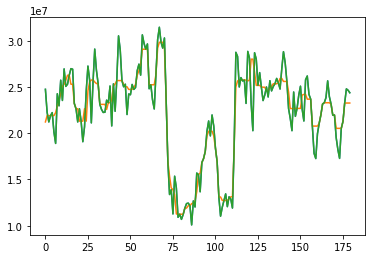

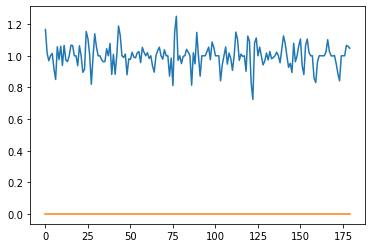

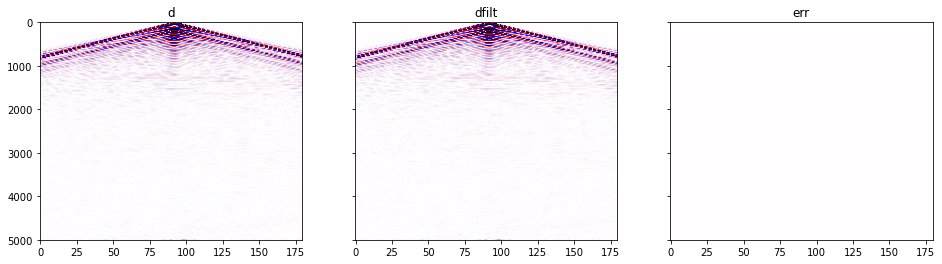

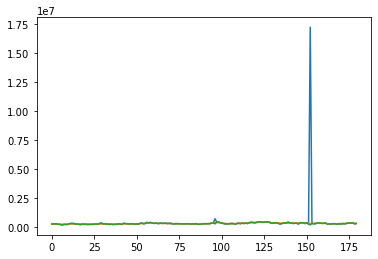

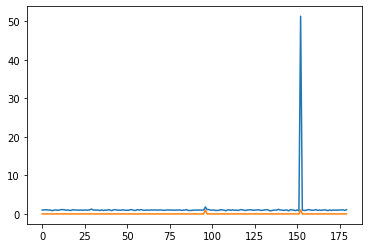

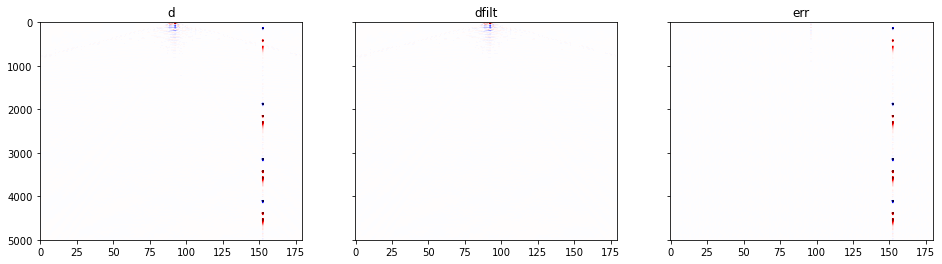

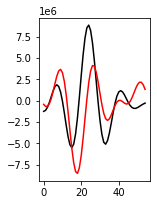

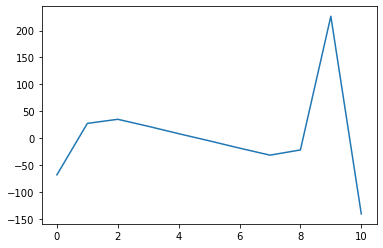

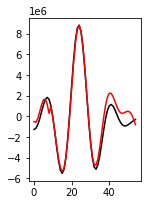

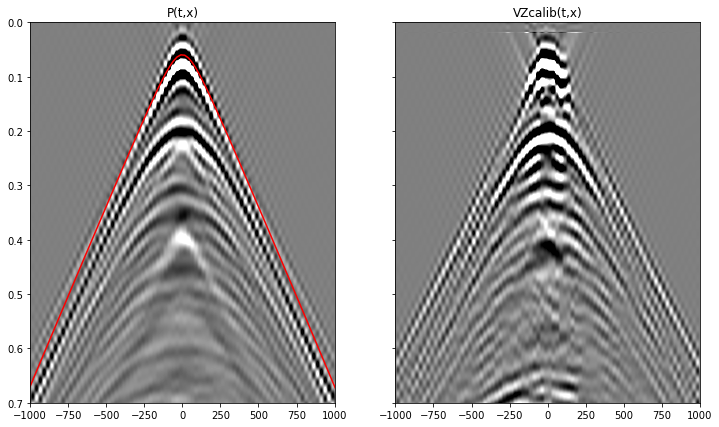

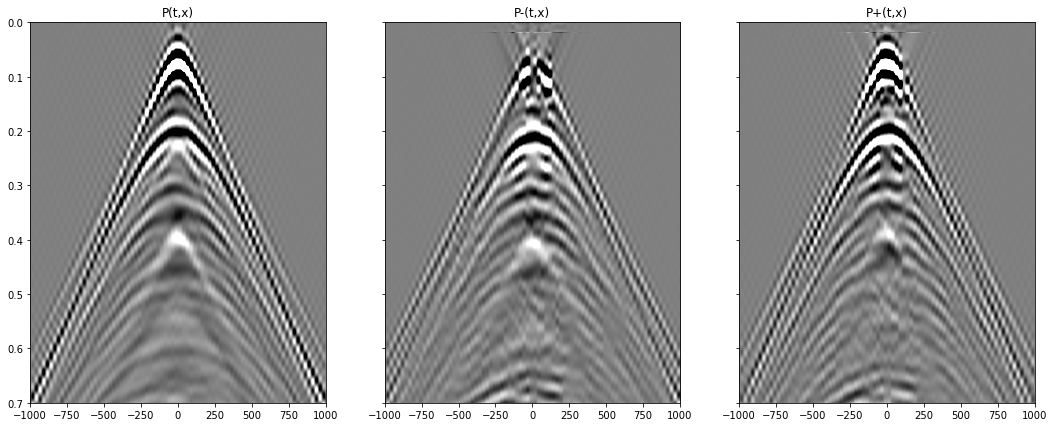

In [67]:
# One shot to check
clip = 1e-1
tmax=0.7

_ = calibrated_wavefield_separation(sg, ishotc, 
                                    izmin=izmin, nmed=nmed, threshmax=threshmax, threshmin=threshmin, #fix_corrupt
                                    fmax=fmax, nlpf=nlpf, # low_pass_filter
                                    vwater=vel_dir, nfilt=nfilt, twin=twin, 
                                    vel_sep=vel_sep, rho_sep=rho_sep, # calibration
                                    critical=critical, ntapermask=ntapermask, # fk filter
                                    plotflag=True, vzsc=60, imclip=clip, tmax=tmax, offmax=1000)

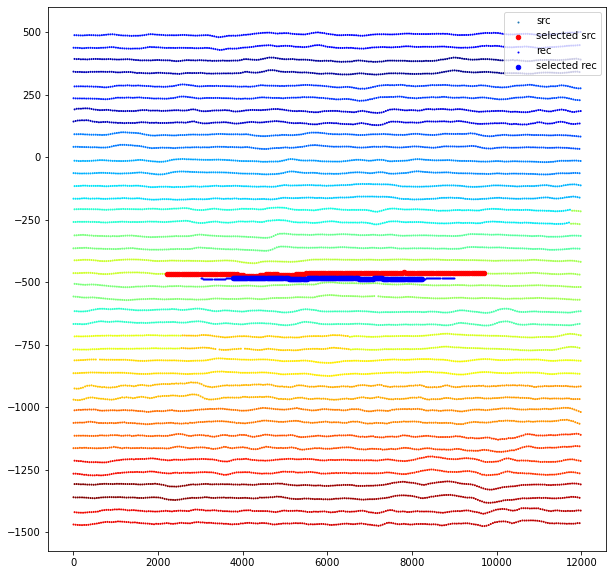

In [68]:
startshot=ishotin
endshot=ishotend
jshot = 2
nshots = endshot - startshot

sg.selectrecs(irecin, irecend, plotflag=False)
sg.selectsrcs(startshot, endshot+1, jshot, plotflag=False)
sg.showgeometry(local=True)

nshots = len(sg.selected_src)
nrecs = len(sg.selected_rec)
pfilt2d = np.zeros((nshots, nrecs, sg.nt))
vzcalib2d  = np.zeros((nshots, nrecs, sg.nt))
pup2d = np.zeros((nshots, nrecs, sg.nt))
pdown2d  = np.zeros((nshots, nrecs, sg.nt))
p_zo = np.zeros((nshots, sg.nt))
vz_zo = np.zeros((nshots, sg.nt))
pup_zo = np.zeros((nshots, sg.nt))
pdown_zo = np.zeros((nshots, sg.nt))
rec_x_zo = np.zeros(nshots)
rec_y_zo = np.zeros(nshots)

for i, shot in enumerate(range(startshot, endshot, jshot)):
    pfilt2d[i], _, vzcalib2d[i], pup2d[i], pdown2d[i], _, p_zo[i], vz_zo[i], pup_zo[i], pdown_zo[i], rec_x_zo[i], rec_y_zo[i] = \
        calibrated_wavefield_separation(sg, shot, 
                                        izmin=izmin, nmed=nmed, threshmax=threshmax, threshmin=threshmin, #fix_corrupt
                                        fmax=fmax, nlpf=nlpf, # low_pass_filter
                                        vwater=vel_dir, nfilt=nfilt, twin=twin, 
                                        vel_sep=vel_sep, rho_sep=rho_sep, # calibration
                                        critical=critical, ntapermask=ntapermask, # fk filter
                                        plotflag=False)

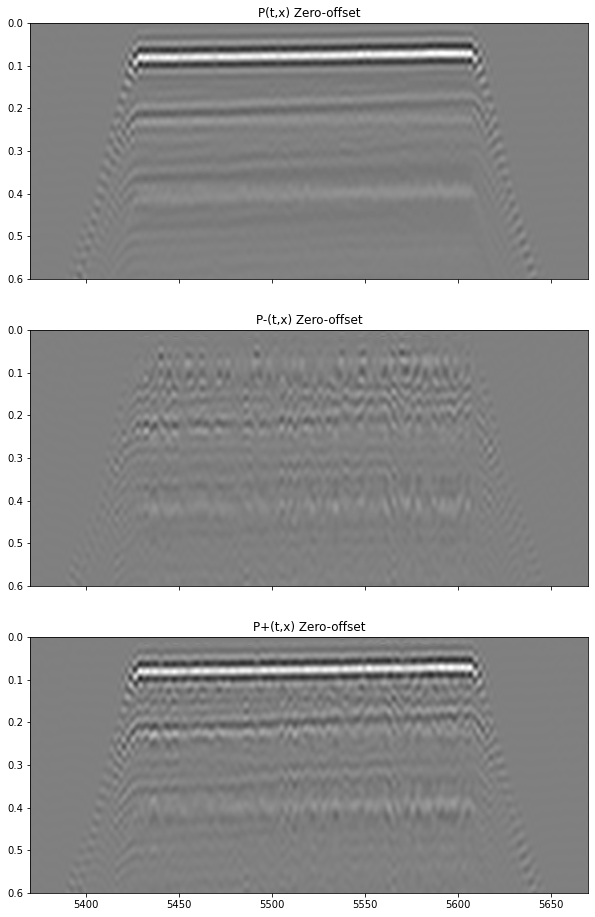

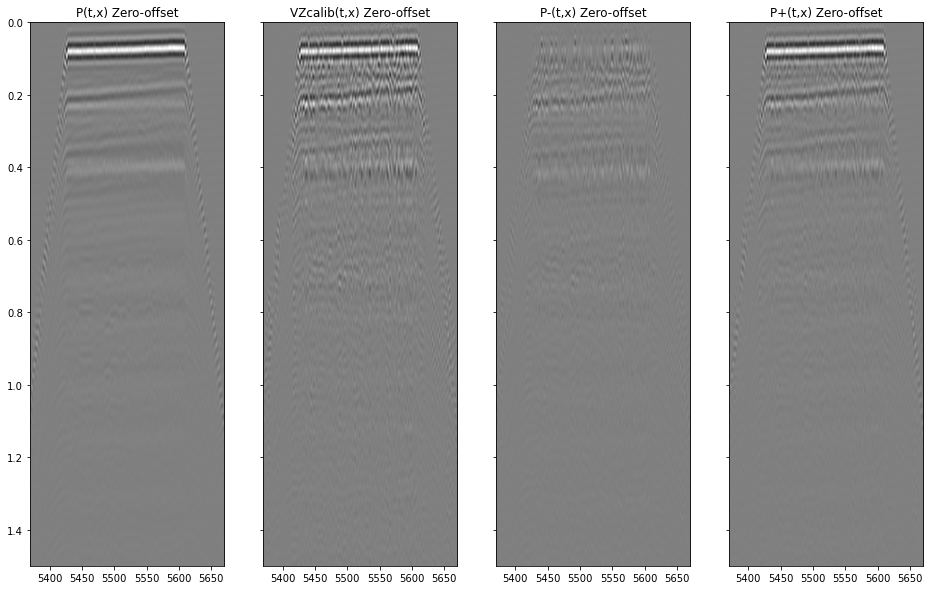

In [69]:
clip = 1e7

fig, axs = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(10, 16))
axs[0].imshow(p_zo.T, cmap='gray', vmin=-clip, vmax=clip, interpolation='sinc',
             extent=(startshot, endshot, sg.t[-1], sg.t[0]))
axs[0].set_title('P(t,x) Zero-offset')
axs[0].axis('tight')
axs[1].imshow(pup_zo.T, cmap='gray', vmin=-clip, vmax=clip, interpolation='sinc',
             extent=(startshot, endshot, sg.t[-1], sg.t[0]))
axs[1].set_title('P-(t,x) Zero-offset')
axs[1].axis('tight')
axs[2].imshow(pdown_zo.T, cmap='gray', vmin=-clip, vmax=clip, interpolation='sinc',
             extent=(startshot, endshot, sg.t[-1], sg.t[0]))
axs[2].set_title('P+(t,x) Zero-offset')
axs[2].axis('tight')
axs[2].set_ylim(.6, 0.);

clip = 1e7

fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16, 10))
axs[0].imshow(p_zo.T, cmap='gray', 
              vmin=-clip, vmax=clip, interpolation='sinc',
              extent=(startshot, endshot, sg.t[-1], sg.t[0]))
axs[0].set_title('P(t,x) Zero-offset')
axs[0].axis('tight')
axs[1].imshow(vz_zo.T * (vel_sep * rho_sep), cmap='gray', 
              vmin=-clip, vmax=clip, interpolation='sinc',
              extent=(startshot, endshot, sg.t[-1], sg.t[0]))
axs[1].set_title('VZcalib(t,x) Zero-offset')
axs[1].axis('tight')
axs[2].imshow(pup_zo.T, cmap='gray', 
              vmin=-clip, vmax=clip, interpolation='sinc',
              extent=(startshot, endshot, sg.t[-1], sg.t[0]))
axs[2].set_title('P-(t,x) Zero-offset')
axs[2].axis('tight')
axs[3].imshow(pdown_zo.T, cmap='gray', 
              vmin=-clip, vmax=clip, interpolation='sinc',
              extent=(startshot, endshot, sg.t[-1], sg.t[0]))
axs[3].set_title('P+(t,x) Zero-offset')
axs[3].axis('tight')
axs[3].set_ylim(1.5, 0.);

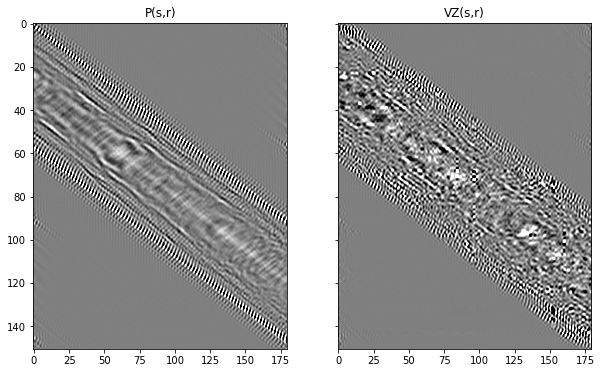

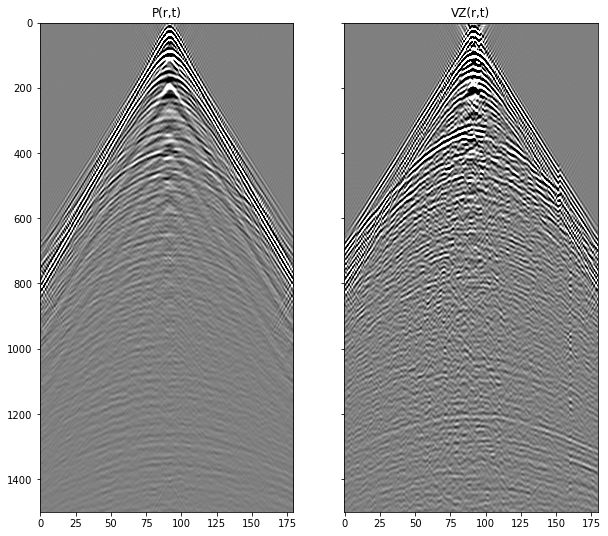

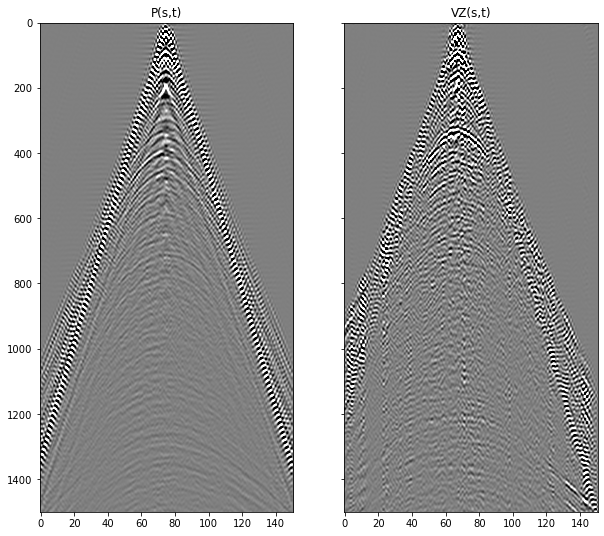

In [70]:
clip = 4e5

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 6))
axs[0].imshow(pfilt2d[..., 500], cmap='gray', vmin=-clip, vmax=clip, interpolation='sinc')
axs[0].set_title('P(s,r)')
axs[0].axis('tight')
axs[1].imshow(vzcalib2d[..., 500] * rho_sep * vel_sep, cmap='gray', vmin=-clip, vmax=clip, interpolation='sinc')
axs[1].set_title('VZ(s,r)')
axs[1].axis('tight');

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 9))
axs[0].imshow(pfilt2d[nshots//2].T, cmap='gray', vmin=-clip, vmax=clip, interpolation='sinc')
axs[0].set_title('P(r,t)')
axs[0].axis('tight')
axs[1].imshow(vzcalib2d[nshots//2].T * rho_sep * vel_sep, cmap='gray', vmin=-clip, vmax=clip, interpolation='sinc')
axs[1].set_title('VZ(r,t)')
axs[1].axis('tight')
axs[1].set_ylim(1500, 0)

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 9))
axs[0].imshow(pfilt2d[:, nrecs//2].T, cmap='gray', vmin=-clip, vmax=clip, interpolation='sinc')
axs[0].set_title('P(s,t)')
axs[0].axis('tight')
axs[1].imshow(vzcalib2d[:, nshots//2].T * rho_sep * vel_sep, cmap='gray', vmin=-clip, vmax=clip, interpolation='sinc')
axs[1].set_title('VZ(s,t)')
axs[1].axis('tight')
axs[1].set_ylim(1500, 0);

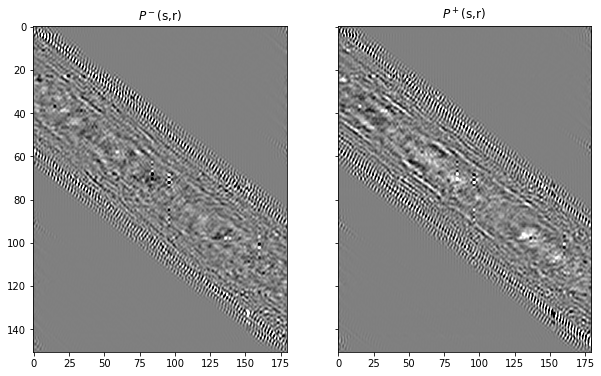

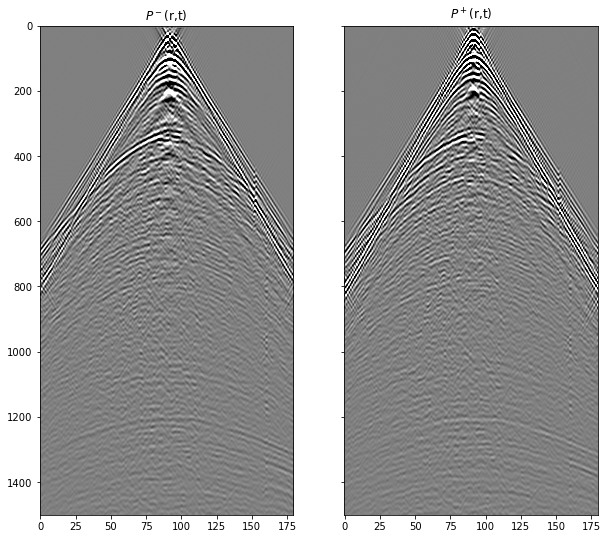

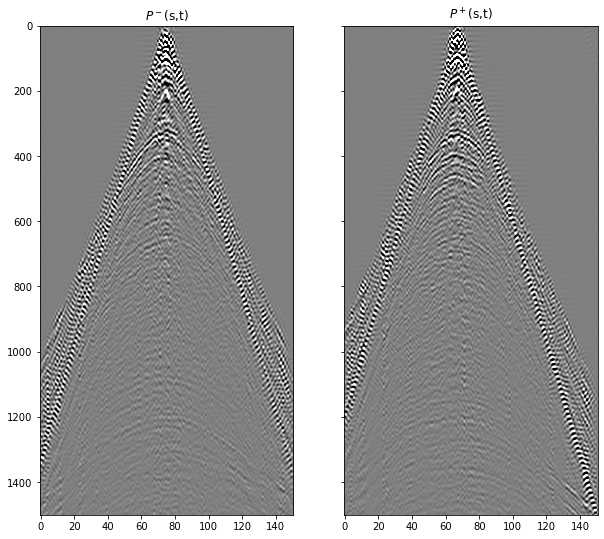

In [71]:
clip = 4e5

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 6))
axs[0].imshow(pup2d[..., 500], cmap='gray', vmin=-clip, vmax=clip, interpolation='sinc')
axs[0].set_title(r'$P^-$(s,r)')
axs[0].axis('tight')
axs[1].imshow(pdown2d[..., 500], cmap='gray', vmin=-clip, vmax=clip, interpolation='sinc')
axs[1].set_title(r'$P^+$(s,r)')
axs[1].axis('tight');

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 9))
axs[0].imshow(pup2d[nshots//2].T, cmap='gray', vmin=-clip, vmax=clip, interpolation='sinc')
axs[0].set_title(r'$P^-$(r,t)')
axs[0].axis('tight')
axs[1].imshow(pdown2d[nshots//2].T, cmap='gray', vmin=-clip, vmax=clip, interpolation='sinc')
axs[1].set_title(r'$P^+$(r,t)')
axs[1].axis('tight')
axs[1].set_ylim(1500, 0)

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 9))
axs[0].imshow(pup2d[:, nrecs//2].T, cmap='gray', vmin=-clip, vmax=clip, interpolation='sinc')
axs[0].set_title(r'$P^-$(s,t)')
axs[0].axis('tight')
axs[1].imshow(pdown2d[:, nshots//2].T, cmap='gray', vmin=-clip, vmax=clip, interpolation='sinc')
axs[1].set_title(r'$P^+$(s,t)')
axs[1].axis('tight')
axs[1].set_ylim(1500, 0);

## Single virtual source MDD

In [72]:
nt = 3000
t = sg.t[:nt]
dt = t[1]-t[0]
dr = 25
nfmax = 450
nfft = nt

# Rearrange data
pup = pup2d.transpose(2,0,1)[:nt]
pdown = pdown2d.transpose(2,0,1)[:nt]

# Rescale to get values around 1)
pdown = pdown / 4e7
pup = pup / 4e7

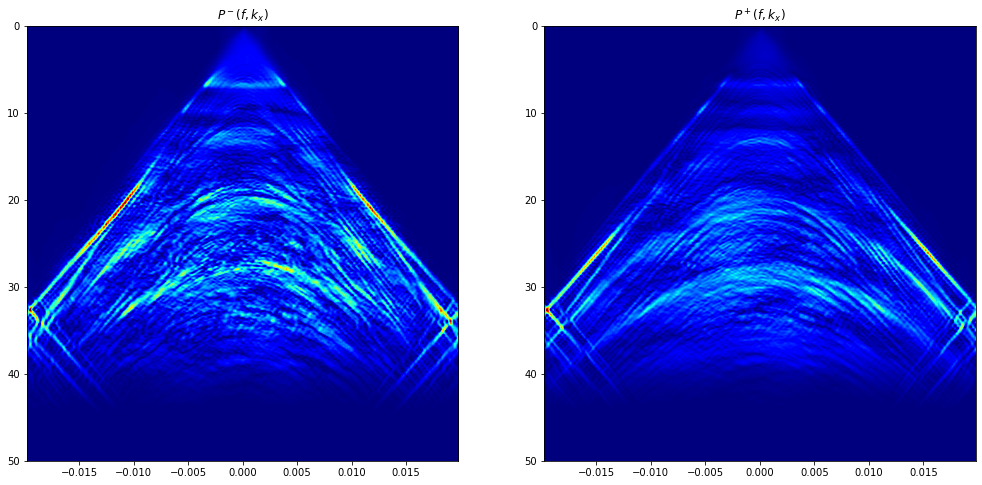

In [73]:
FFTop = FFT2D(dims=[nrecs, nt], nffts=[nrecs, nfft], sampling=[dr, dt])
PUP = (FFTop*pup[:, nshots//2].T.flatten()).reshape(nrecs, nfft)
PDOWN = (FFTop*pdown[:, nshots//2].T.flatten()).reshape(nrecs, nfft)

clip = 0.1
fig, axs = plt.subplots(1, 2, figsize=(17, 8))
axs[0].imshow(np.fft.fftshift(np.abs(PUP[:, :nfft//2-1]),axes=0).T, 
                 cmap='jet', interpolation='sinc',
                 extent = (-FFTop.f1[nrecs//2-1], FFTop.f1[nrecs//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(PUP).max())
axs[0].axhline(FFTop.f2[nfmax], color='w')
axs[0].set_title(r'$P^-(f, k_x)$')
axs[0].axis('tight')
axs[0].set_ylim(50, 0);           
axs[1].imshow(np.fft.fftshift(np.abs(PDOWN[:, :nfft//2-1]),axes=0).T, 
                 cmap='jet', interpolation='sinc',
                 extent = (-FFTop.f1[nrecs//2-1], FFTop.f1[nrecs//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(PDOWN).max())
axs[1].axhline(FFTop.f2[nfmax], color='w')
axs[1].set_title(r'$P^+(f, k_x)$')
axs[1].axis('tight')
axs[1].set_ylim(50, 0);

### Benchmark MDD

In [74]:
PDOWN = np.fft.rfft(pdown, nt, axis=0)
PDOWN = PDOWN[:nfmax]

MDCop = MDC(PDOWN, nt=nt,
            nv=1, dt=dt, dr=dr, 
            twosided=False, transpose=False)
# Adjoint
Radj = MDCop.H * pup[:, :, nrecs//2].ravel()
Radj = np.real(Radj).reshape(nt, nrecs)

In [75]:
# Inverse
niter = 40
Rinv, _, _, _, _, Rinv_res = \
    cgls(MDCop, pup[:, :, nrecs//2].ravel(), niter=niter, 
         x0=np.zeros((nt, nrecs)).ravel(), damp=1e-9, tol=0., show=1)
Rinv = np.real(Rinv).reshape(nt, nrecs)
Rinv_res = Rinv_res**2 / (nt * nshots)

pupinv = MDCop * Rinv.ravel()
pupinv = pupinv.reshape(nt, nshots)

CGLS
-----------------------------------------------------------
The Operator Op has 453000 rows and 540000 cols
damp = 1.000000e-09	tol = 0.000000e+00	niter = 40
-----------------------------------------------------------
    Itn           x[0]              r1norm          r2norm
     1         4.8422e-06         1.0078e+00      1.0078e+00
     2         1.2526e-05         8.3033e-01      8.3033e-01
     3         1.4400e-05         7.3547e-01      7.3547e-01
     4         1.5274e-05         6.7410e-01      6.7410e-01
     5         1.5917e-05         6.1863e-01      6.1863e-01
     6         1.5784e-05         5.7432e-01      5.7432e-01
     7         1.7333e-05         5.4025e-01      5.4025e-01
     8         2.0956e-05         5.0978e-01      5.0978e-01
     9         2.5304e-05         4.8739e-01      4.8739e-01
    10         3.4265e-05         4.6643e-01      4.6643e-01
    20         5.9584e-05         3.5610e-01      3.5610e-01
    30         5.2236e-05         3.0670e-01   

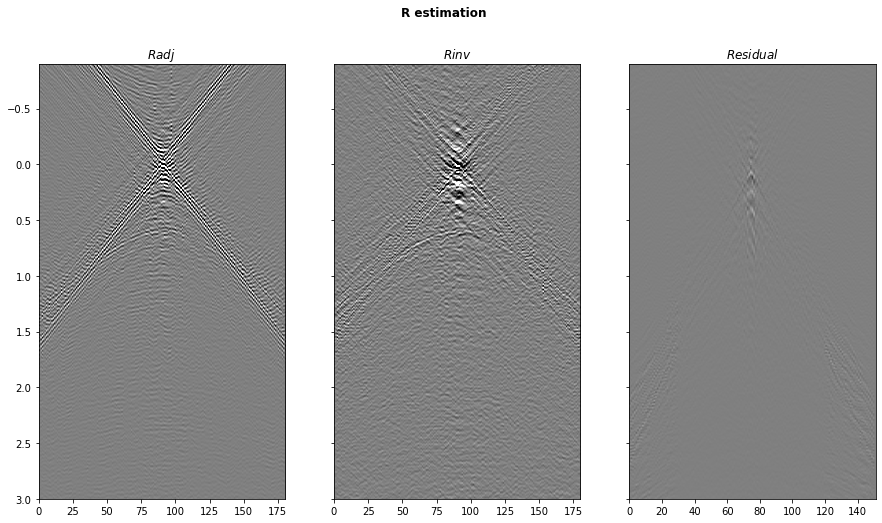

In [76]:
clip = 0.1
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 8))
fig.suptitle('R estimation', fontweight='bold')
axs[0].imshow(np.fft.fftshift(Radj,axes=0), cmap='gray', 
              vmin=-clip*np.abs(Radj).max(), vmax=clip*np.abs(Radj).max(),
              extent = (0, nrecs, t[-1]/2, -t[-1]/2))
axs[0].set_title(r'$Radj$')
axs[0].axis('tight')
axs[1].imshow(np.fft.fftshift(Rinv,axes=0), cmap='gray', 
              vmin=-clip*np.abs(Rinv).max(), vmax=clip*np.abs(Rinv).max(),
              extent = (0, nrecs, t[-1]/2, -t[-1]/2))
axs[1].set_title(r'$Rinv$')
axs[1].axis('tight')
axs[2].imshow(np.fft.fftshift(pup[:, :, nrecs//2]-pupinv,axes=0), cmap='gray', 
              vmin=-clip*np.abs(pup).max(), vmax=clip*np.abs(pup).max(),
              extent = (0, nshots, t[-1]/2, -t[-1]/2))
axs[2].set_title(r'$Residual$')
axs[2].axis('tight')
axs[2].set_ylim(3, -.9);

### Stochastic MDD

In [77]:
nepochs = niter
batch_size = 32

no_of_batches= int(np.ceil(nshots/batch_size))
lossdict = {}
avgdict = {}
lossepochdict = {}
mdict = {}

In [78]:
PDOWN = np.fft.rfft(pdown, nt, axis=0)
PDOWN = PDOWN[:nfmax]

PDOWN = torch.from_numpy(PDOWN)
pup = torch.from_numpy(pup[..., nrecs//2])

In [79]:
pup.max(), torch.abs(PDOWN).max()

(tensor(0.1121, dtype=torch.float64), tensor(7.7195, dtype=torch.float64))

In [85]:
print(np.sum(np.abs(pup.numpy().ravel())**2)), print(np.sum(np.abs(PDOWN.numpy().ravel())**2))

1.3784368031104737
725941.7444286527


(None, None)

In [84]:
lr = {}
lr[32] = 30

model, dmod, lossdict['SGD'], avgdict['SGD'], lossepochdict['SGD'], _, _ = \
                 MDDminibatch(nt, nrecs, dt, dr, PDOWN, pup, torch.optim.SGD, 
                              nepochs, batch_size, twosided=False, mtrue=None, seed=0, epochprint=5,
                              **dict(lr=lr[batch_size], weight_decay=0))
mdict["SGD"] = model.detach().numpy()

Initial Gradient norm: 7.553921e-08, Scaled: 6.798529e-05
epoch:   5, loss : 8.4531e-07, loss avg : 8.9616e-07
epoch:  10, loss : 4.0849e-07, loss avg : 5.8329e-07
epoch:  15, loss : 7.0456e-07, loss avg : 4.9686e-07
epoch:  20, loss : 3.2684e-07, loss avg : 4.1525e-07
epoch:  25, loss : 3.1805e-07, loss avg : 3.7789e-07
epoch:  30, loss : 2.6978e-07, loss avg : 3.4721e-07
epoch:  35, loss : 2.7758e-07, loss avg : 3.2368e-07
epoch:  40, loss : 2.6466e-07, loss avg : 3.0786e-07
Final Model norm: 4.598367e-03


In [81]:
# First loss 
np.sum(np.abs(pup.reshape(-1).numpy())**2) / (len(pup.reshape(-1))), lossepochdict['SGD'][0], Rinv_res[0]

(3.042906850133496e-06, 3.0429068501334956e-06, 3.0429068501334964e-06)

In [82]:
print(np.sum(np.abs(model.detach().numpy().ravel())**2))

0.0023774931466632554


In [87]:
725941 * 6.8e-5, 1.3

(49.363988, 1.3)

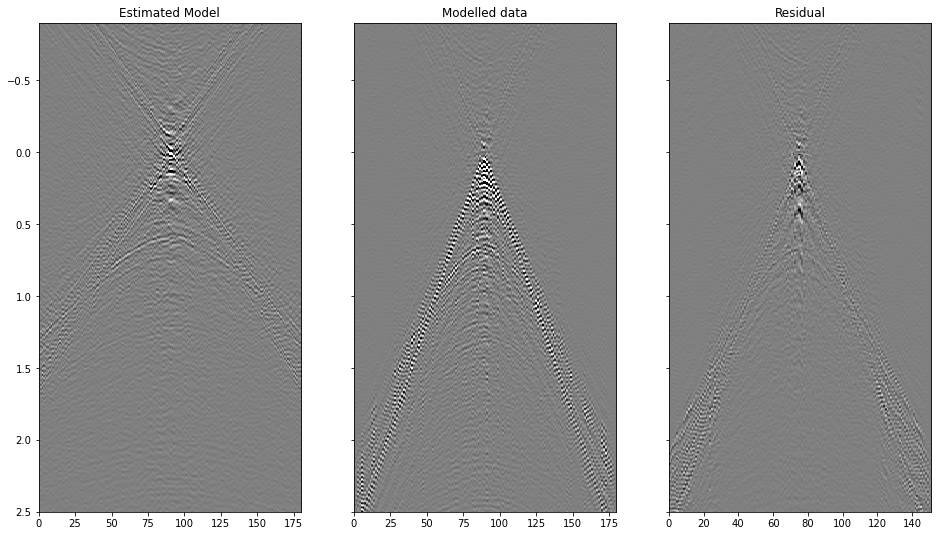

In [54]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16, 9))
ax1.imshow(np.fft.fftshift(model.detach().numpy(),axes=0), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*np.abs(Rinv).max(), vmax=clip*np.abs(Rinv).max(),
           extent = (0, nrecs, t[-1]/2, -t[-1]/2))
ax1.set_title('Estimated Model')
ax2.imshow(np.fft.fftshift(dmod.detach().numpy(),axes=0), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*pup.detach().numpy().max(), vmax=clip*pup.detach().numpy().max(),
           extent = (0, nrecs, t[-1]/2, -t[-1]/2))
ax2.set_title('Modelled data')
ax3.imshow(np.fft.fftshift((dmod-pup).detach().numpy(),axes=0), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*np.abs(pup).max(), vmax=clip*np.abs(pup).max(),
           extent = (0, nshots, t[-1]/2, -t[-1]/2))
ax3.set_title('Residual')
ax3.set_ylim(2.5, -.9);

In [26]:
lr = {}
lr[32] = 10

model, dmod, lossdict['SGDMom'], avgdict['SGDMom'], lossepochdict['SGDMom'], _, _ = \
                 MDDminibatch(nt, nrecs, dt, dr, PDOWN, pup, torch.optim.SGD, 
                              nepochs, batch_size, twosided=False, mtrue=None, seed=0, epochprint=5,
                              **dict(lr=lr[batch_size], weight_decay=1e-4, momentum=0.8, nesterov=True))
mdict["SGDMom"] = model.detach().numpy()

epoch:   5, loss : 6.8180e-07, loss avg : 7.0762e-07
epoch:  10, loss : 3.4102e-07, loss avg : 4.8771e-07
epoch:  15, loss : 6.2586e-07, loss avg : 4.3479e-07
epoch:  20, loss : 2.9018e-07, loss avg : 3.7990e-07
epoch:  25, loss : 2.9532e-07, loss avg : 3.6093e-07
epoch:  30, loss : 2.6029e-07, loss avg : 3.4226e-07
epoch:  35, loss : 2.8612e-07, loss avg : 3.3243e-07
epoch:  40, loss : 2.8045e-07, loss avg : 3.2638e-07


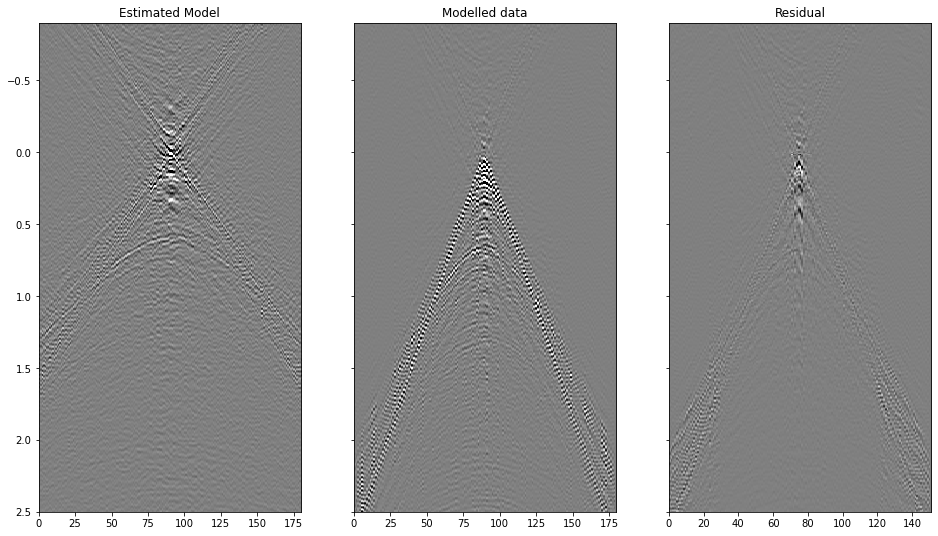

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16, 9))
ax1.imshow(np.fft.fftshift(model.detach().numpy(),axes=0), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*np.abs(Rinv).max(), vmax=clip*np.abs(Rinv).max(),
           extent = (0, nrecs, t[-1]/2, -t[-1]/2))
ax1.set_title('Estimated Model')
ax2.imshow(np.fft.fftshift(dmod.detach().numpy(),axes=0), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*pup.detach().numpy().max(), vmax=clip*pup.detach().numpy().max(),
           extent = (0, nrecs, t[-1]/2, -t[-1]/2))
ax2.set_title('Modelled data')
ax3.imshow(np.fft.fftshift((dmod-pup).detach().numpy(),axes=0), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip*np.abs(pup).max(), vmax=clip*np.abs(pup).max(),
           extent = (0, nshots, t[-1]/2, -t[-1]/2))
ax3.set_title('Residual')
ax3.set_ylim(2.5, -.9);

In [28]:
lr = {}
lr[21] = 0.01
lr[32] = 0.01
lr[64] = 0.01

model, dmod, lossdict['SGDMom_LRexp'], avgdict['SGDMom_LRexp'], lossepochdict['SGDMom_LRexp'], _, lr = \
                 MDDminibatch(nt, nrecs, dt, dr, PDOWN, pup, torch.optim.SGD, 
                              nepochs, batch_size, twosided=False, mtrue=None, seed=0,
                              scheduler=torch.optim.lr_scheduler.ExponentialLR, epochprint=5,
                              kwargs_sched=dict(gamma=0.97, last_epoch=-1, verbose=False),
                              **dict(lr=lr[batch_size], weight_decay=1e-4, momentum=0.8, nesterov=True))
                 
mdict["SGDMom_LRexp"] = model.detach().numpy()

epoch:   5, loss : 2.3033e-06, loss avg : 2.9840e-06
epoch:  10, loss : 1.8674e-06, loss avg : 2.9477e-06
epoch:  15, loss : 3.8196e-06, loss avg : 3.0520e-06
epoch:  20, loss : 1.7940e-06, loss avg : 2.9355e-06
epoch:  25, loss : 1.6247e-06, loss avg : 2.9248e-06
epoch:  30, loss : 1.7944e-06, loss avg : 2.9338e-06
epoch:  35, loss : 2.1244e-06, loss avg : 2.9521e-06
epoch:  40, loss : 2.1487e-06, loss avg : 2.9534e-06


NameError: name 'ivs' is not defined

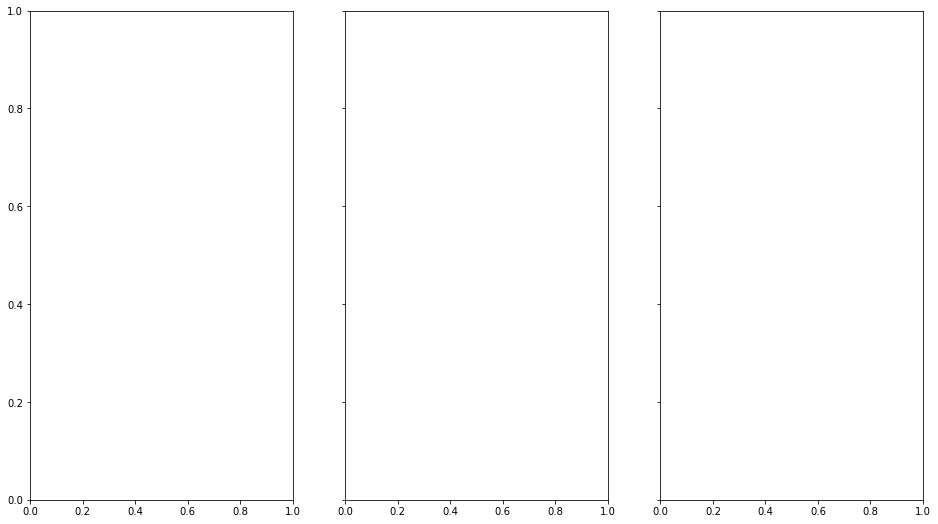

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16, 9))
ax1.imshow(np.fft.fftshift(model[..., ivs].detach().numpy(),axes=0), aspect='auto', 
           interpolation='nearest', cmap='gray',
           vmin=-clip*np.abs(Rinv[..., ivs]).max(), vmax=clip*np.abs(Rinv[..., ivs]).max(),
           extent = (0, nrecs, t[-1]/2, -t[-1]/2))
ax1.set_title('Estimated Model')
ax2.imshow(np.fft.fftshift(dmod[..., ivs].detach().numpy(),axes=0), aspect='auto',
           interpolation='nearest', cmap='gray',
           vmin=-clip*pup[..., ivs].detach().numpy().max(), vmax=clip*pup[..., ivs].detach().numpy().max(),
           extent = (0, nrecs, t[-1]/2, -t[-1]/2))
ax2.set_title('Modelled data')
ax3.imshow(np.fft.fftshift((dmod-pup)[..., ivs].detach().numpy(),axes=0), aspect='auto', 
           interpolation='nearest', cmap='gray',
           vmin=-clip*np.abs(pup[..., ivs]).max(), vmax=clip*np.abs(pup[..., ivs]).max(),
           extent = (0, nshots, t[-1]/2, -t[-1]/2))
ax3.set_title('Residual')
ax3.set_ylim(2.5, -.9);

### Comparison

In [ ]:
clip = 0.05
fig, axs = plt.subplots(1, 1+len(mdict), sharey=True, figsize=(16, 9))
axs[0].imshow(np.fft.fftshift(Rinv,axes=0), aspect='auto', interpolation='nearest', cmap='gray',
              vmin=-clip*np.abs(Rinv).max(), vmax=clip*np.abs(Rinv).max(),
              extent = (0, nrecs, t[-1]/2, -t[-1]/2))
axs[0].set_title('MDD')

for imod, mod in enumerate(mdict.keys()):

    axs[imod+1].imshow(np.fft.fftshift(mdict[mod],axes=0), aspect='auto', interpolation='nearest', cmap='gray',
                       vmin=-clip*np.abs(Rinv).max(), vmax=clip*np.abs(Rinv).max(),
                       extent = (0, nrecs, t[-1]/2, -t[-1]/2))
    axs[imod+1].set_title(mod)
axs[-1].set_ylim(2.5, -.9);

In [ ]:
colors = ('r', 'b', 'g')
nepochs = 20

fig = plt.figure(figsize= (12,6))
plt.plot(np.arange(nepochs), Rinv_res[:nepochs], 'k', label='lsqr')
for loss, color in zip(lossdict.keys(), colors):
    plt.plot(np.arange(nepochs+1), lossepochdict[loss][:nepochs+1], color, label = str(loss).split()[0])
plt.xlabel('n_epochs')
plt.ylabel('||r||_2')
plt.title('Residual norms (at the end of each epoch)')
plt.legend()
plt.tight_layout()
plt.savefig('Figs/MDDSaltSingle_finalresidual_batch%d_nepoch%d' % (batch_size, nepochs))

## Multi virtual source MDD

In [ ]:
# 10 vs
#reciprocity=False
#ivs = 5
#nvsin = nrecs//2-5
#nvsend = nrecs//2+6

# all vs
reciprocity = True #False
ivs = nrecs//2
nvsin = 0
nvsend = nrecs

nvs = nvsend-nvsin
nvs

In [ ]:
nt = 3000
t = sg.t[:nt]
dt = t[1]-t[0]
dr = 25
nfmax = 450
nfft = nt

# Rearrange data
pup = pup2d.transpose(2,0,1)[:nt]
pdown = pdown2d.transpose(2,0,1)[:nt]

# Rescale to get values around 1)
pdown = pdown / 4e7
pup = pup / 4e7

### Benchmark MDD

In [ ]:
PDOWN = np.fft.rfft(pdown, nt, axis=0)
PDOWN = PDOWN[:nfmax]

MDCop = MDC(PDOWN, nt=nt,
            nv=nrecs, dt=dt, dr=dr, 
            twosided=False, transpose=False)

# Reciprocity prec
if reciprocity:
    Recop =  0.5 * (Identity(nt * nrecs * nrecs) + \
            gedSC        Transpose((nt, nrecs, nrecs), (0, 2, 1)))
    MDCop = MDCop * Recop

# Adjoint
Radj = MDCop.H * pup[:, :, nvsin:nvsend].ravel()
Radj = np.real(Radj).reshape(nt, nrecs, nvs)

In [ ]:
# Inversion
niter = 40
Rinv, _, _, _, _, bench_resnorm = \
    cgls(MDCop, pup[:, :, nvsin:nvsend].ravel(), niter=niter, 
         x0=np.zeros((nt, nrecs, nvs)).ravel(), damp=1e-9, tol=0., show=1)
Rinv = np.real(Rinv).reshape(nt, nrecs, nrecs)
bench_resnorm = bench_resnorm**2 / (nt * nshots * nvs)

pupinv = MDCop * Rinv.ravel()
pupinv = pupinv.reshape(nt, nshots, nvs)

In [ ]:
clip = 0.1
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(13, 8))
fig.suptitle('R estimation (CRG)', fontweight='bold')
axs[0].imshow(np.fft.fftshift(Radj[:, nrecs//2], axes=0), cmap='gray', 
              vmin=-clip*np.abs(Radj[:, nrecs//2]).max(), vmax=clip*np.abs(Radj[:, nrecs//2]).max(),
              extent = (0, nrecs, t[-1]/2, -t[-1]/2))
axs[0].set_title(r'$Radj$')
axs[0].axis('tight')
axs[1].imshow(np.fft.fftshift(Rinv[:, nrecs//2], axes=0), cmap='gray', 
              vmin=-clip*np.abs(Rinv[:, nrecs//2]).max(), vmax=clip*np.abs(Rinv[:, nrecs//2]).max(),
              extent = (0, nrecs, t[-1]/2, -t[-1]/2))
axs[1].set_title(r'$Rinv$')
axs[1].axis('tight')
axs[2].imshow(np.fft.fftshift((pup-pupinv)[:, nshots//2],axes=0), cmap='gray', 
              vmin=-clip*np.abs(pup[:, nshots//2]).max(), vmax=clip*np.abs(pup[:, nshots//2]).max(),
              extent = (0, nrecs, t[-1]/2, -t[-1]/2))
axs[2].set_title(r'$Residual$')
axs[2].axis('tight')
axs[2].set_ylim(2.5, -.9)

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(13, 8))
fig.suptitle('R estimation (CSVG)', fontweight='bold')
axs[0].imshow(np.fft.fftshift(Radj[:,  :, ivs+nvsin], axes=0), cmap='gray', 
              vmin=-clip*np.abs(Radj[:,  :, ivs+nvsin]).max(), vmax=clip*np.abs(Radj[:,  :, ivs+nvsin]).max(),
              extent = (0, nrecs, t[-1]/2, -t[-1]/2))
axs[0].set_title(r'$Radj$')
axs[0].axis('tight')
axs[1].imshow(np.fft.fftshift(Rinv[:, :, ivs], axes=0), cmap='gray', 
              vmin=-clip*np.abs(Rinv[:, :, ivs+nvsin]).max(), vmax=clip*np.abs(Rinv[:, :, ivs+nvsin]).max(),
              extent = (0, nrecs, t[-1]/2, -t[-1]/2))
axs[1].set_title(r'$Rinv$')
axs[1].axis('tight')
axs[2].imshow(np.fft.fftshift((pup-pupinv)[:, :, ivs],axes=0), cmap='gray', 
              vmin=-clip*np.abs(pup[:, :, ivs]).max(), vmax=clip*np.abs(pup[:, :, ivs]).max(),
              extent = (0, nrecs, t[-1]/2, -t[-1]/2))
axs[2].set_title(r'$Residual$')
axs[2].axis('tight')
axs[2].set_ylim(2.5, -.9);

### Stochastic MDD

In [ ]:
nepochs = niter
batch_size = 32

no_of_batches = int(np.ceil(nshots/batch_size))
lossdict = {}
lossepochdict = {}
avgdict = {}
enormdict = {}
mdict = {}

In [ ]:
PDOWN = np.fft.rfft(pdown, nt, axis=0)
PDOWN = PDOWN[:nfmax]

PDOWN = torch.from_numpy(PDOWN)
pup = torch.from_numpy(pup[:, :, nvsin:nvsend])

In [ ]:
pup.max(), torch.abs(PDOWN).max()

In [ ]:
lr = {}

# all vs
lr[32] = 1000.

model, dmod, lossdict['SGD'], avgdict['SGD'], lossepochdict['SGD'], enormdict['SGD'], _ = \
                 MDDminibatch(nt, nrecs, dt, dr, PDOWN, pup, torch.optim.SGD, 
                              nepochs, batch_size, twosided=False, mtrue=None, ivstrue=ivs, 
                              seed=0, epochprint=5, reciprocity=True,
                              **dict(lr=lr[batch_size], weight_decay=0))
mdict["SGD"] = model.detach().numpy()

In [ ]:
# First loss 
np.sum(np.abs(pup.reshape(-1).numpy())**2) / (len(pup.reshape(-1))), lossepochdict['SGD'][0], bench_resnorm[0]

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16, 9))
ax1.imshow(np.fft.fftshift(model[..., ivs].detach().numpy(),axes=0), aspect='auto', 
           interpolation='nearest', cmap='gray',
           vmin=-clip*np.abs(Rinv[..., ivs]).max(), vmax=clip*np.abs(Rinv[..., ivs]).max(),
           extent = (0, nrecs, t[-1]/2, -t[-1]/2))
ax1.set_title('Estimated Model')
ax2.imshow(np.fft.fftshift(dmod[..., ivs].detach().numpy(),axes=0), aspect='auto',
           interpolation='nearest', cmap='gray',
           vmin=-clip*pup[..., ivs].detach().numpy().max(), vmax=clip*pup[..., ivs].detach().numpy().max(),
           extent = (0, nrecs, t[-1]/2, -t[-1]/2))
ax2.set_title('Modelled data')
ax3.imshow(np.fft.fftshift((dmod-pup)[..., ivs].detach().numpy(),axes=0), aspect='auto', 
           interpolation='nearest', cmap='gray',
           vmin=-clip*np.abs(pup[..., ivs]).max(), vmax=clip*np.abs(pup[..., ivs]).max(),
           extent = (0, nshots, t[-1]/2, -t[-1]/2))
ax3.set_title('Residual')
ax3.set_ylim(2.5, -.9);

In [ ]:
lr = {}

# all vs
lr[32] = 1000.

model, dmod, lossdict['SGDMom'], avgdict['SGDMom'], lossepochdict['SGDMom'], enormdict['SGDMom'], _ = \
                 MDDminibatch(nt, nrecs, dt, dr, PDOWN, pup, torch.optim.SGD, 
                              nepochs, batch_size, twosided=False, mtrue=None, ivstrue=ivs, 
                              seed=0, epochprint=5, reciprocity=True,
                              **dict(lr=lr[batch_size], weight_decay=1e-8, momentum=0.8, nesterov=True))
mdict["SGDMom"] = model.detach().numpy()

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16, 9))
ax1.imshow(np.fft.fftshift(model[..., ivs].detach().numpy(),axes=0), aspect='auto', 
           interpolation='nearest', cmap='gray',
           vmin=-clip*np.abs(Rinv[..., ivs]).max(), vmax=clip*np.abs(Rinv[..., ivs]).max(),
           extent = (0, nrecs, t[-1]/2, -t[-1]/2))
ax1.set_title('Estimated Model')
ax2.imshow(np.fft.fftshift(dmod[..., ivs].detach().numpy(),axes=0), aspect='auto',
           interpolation='nearest', cmap='gray',
           vmin=-clip*pup[..., ivs].detach().numpy().max(), vmax=clip*pup[..., ivs].detach().numpy().max(),
           extent = (0, nrecs, t[-1]/2, -t[-1]/2))
ax2.set_title('Modelled data')
ax3.imshow(np.fft.fftshift((dmod-pup)[..., ivs].detach().numpy(),axes=0), aspect='auto', 
           interpolation='nearest', cmap='gray',
           vmin=-clip*np.abs(pup[..., ivs]).max(), vmax=clip*np.abs(pup[..., ivs]).max(),
           extent = (0, nshots, t[-1]/2, -t[-1]/2))
ax3.set_title('Residual')
ax3.set_ylim(2.5, -.9);

In [ ]:
lr = {}

# all vs
lr[32] = 1000.

model, dmod, lossdict['SGDMom_LRexp'], avgdict['SGDMom_LRexp'], lossepochdict['SGDMom_LRexp'], enormdict['SGDMom_LRexp'], _ = \
                 MDDminibatch(nt, nrecs, dt, dr, PDOWN, pup, torch.optim.SGD, 
                              nepochs, batch_size, twosided=False, mtrue=None, ivstrue=ivs, seed=0, 
                              scheduler=torch.optim.lr_scheduler.ExponentialLR, epochprint=5, reciprocity=True,
                              kwargs_sched=dict(gamma=0.99, last_epoch=-1, verbose=False),
                              **dict(lr=lr[batch_size], weight_decay=1e-8, momentum=0.8, nesterov=True))
mdict["SGDMom_LRexp"] = model.detach().numpy()

### Comparison

In [ ]:
clip = 0.05
ivs = nvs//2

fig, axs = plt.subplots(1, 1+len(mdict), sharey=True, figsize=(16, 9))
fig.suptitle('CVSG', fontsize=18, fontweight='bold', y=.95)
axs[0].imshow(np.fft.fftshift(Rinv[:nt, :, ivs],axes=0), aspect='auto', interpolation='nearest', cmap='gray',
              vmin=-clip*np.abs(Rinv[:nt, :, ivs]).max(), vmax=clip*np.abs(Rinv[:nt, :, ivs]).max(),
              extent = (0, nrecs, t[-1]/2, -t[-1]/2))
axs[0].set_title('MDD')

for imod, mod in enumerate(mdict.keys()):

    axs[imod+1].imshow(np.fft.fftshift(mdict[mod][:nt, :, ivs],axes=0), aspect='auto', interpolation='nearest', cmap='gray',
                       vmin=-clip*np.abs(Rinv[:nt, :, ivs]).max(), vmax=clip*np.abs(Rinv[:nt, :, ivs]).max(),
                       extent = (0, nrecs, t[-1]/2, -t[-1]/2))
    axs[imod+1].set_title(mod)
axs[-1].set_ylim(2.5, -.9);

In [ ]:
clip = 0.05
ir = nrecs//2

fig, axs = plt.subplots(1, 1+len(mdict), sharey=True, figsize=(16, 9))
fig.suptitle('CRG', fontsize=18, fontweight='bold', y=.95)
axs[0].imshow(np.fft.fftshift(Rinv[:nt, ir],axes=0), aspect='auto', interpolation='nearest', cmap='gray',
              vmin=-clip*np.abs(Rinv[:nt, ir]).max(), vmax=clip*np.abs(Rinv[:nt, ir]).max(),
              extent = (0, nrecs, t[-1]/2, -t[-1]/2))
axs[0].set_title('MDD')

for imod, mod in enumerate(mdict.keys()):

    axs[imod+1].imshow(np.fft.fftshift(mdict[mod][:nt, ir],axes=0), aspect='auto', interpolation='nearest', cmap='gray',
                       vmin=-clip*np.abs(Rinv[:nt, ir]).max(), vmax=clip*np.abs(Rinv[:nt, ir]).max(),
                       extent = (0, nrecs, t[-1]/2, -t[-1]/2))
    axs[imod+1].set_title(mod)
axs[-1].set_ylim(2.5, -.9);

In [ ]:
colors = ('r', 'b', 'g')
nepochs = 10

fig = plt.figure(figsize= (12,6))
plt.plot(np.arange(nepochs), Rinv_res[:nepochs], 'k', label='lsqr')
for loss, color in zip(lossdict.keys(), colors):
    plt.plot(np.arange(nepochs+1), lossepochdict[loss][:nepochs+1], color, label = str(loss).split()[0])
plt.xlabel('n_epochs')
plt.ylabel('||r||_2')
plt.title('Residual norms (at the end of each epoch)')
plt.legend()
plt.tight_layout()
plt.savefig('Figs/MDDSaltMulti_finalresidual_batch%d_nepoch%d' % (batch_size, nepochs))